### Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint


### Load Dataset

In [ ]:
df = pd.read_csv("../data/gsearch_jobs.csv")
print(df.head())
print(df.shape)

   Unnamed: 0  index                                             title  \
0           0      0                                      Data Analyst   
1           1      1                                      Data Analyst   
2           2      2                         Aeronautical Data Analyst   
3           3      3  Data Analyst - Consumer Goods - Contract to Hire   
4           4      4               Data Analyst | Workforce Management   

                 company_name            location           via  \
0                        Meta           Anywhere   via LinkedIn   
1                         ATC    United States     via LinkedIn   
2  Garmin International, Inc.       Olathe, KS       via Indeed   
3                      Upwork           Anywhere     via Upwork   
4                Krispy Kreme    United States     via LinkedIn   

                                         description  \
0  In the intersection of compliance and analytic...   
1  Job Title: Entry Level Business Analy

### Target (salary_yearly)

In [ ]:
# Keep rows with yearly salary
df = df[df["salary_yearly"].notna()].copy()

In [ ]:
# Light cleaning (the pipeline will handle the rest)
df["title"] = df["title"].astype(str).str.strip()
df["job_platform"] = df["via"].astype(str).str.strip().str.replace(r"^via\s+", "", regex=True)
df["location"] = df["location"].astype(str).str.strip()

In [28]:
# Features + Target
features = ["title", "job_platform", "location"]
X = df[features]
y = df["salary_yearly"]

### Preprocessing pipeline

In [ ]:
#Handles NaN + Encoding
preprocess = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
                    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value",
                                               unknown_value=-1))
                ]
            ),
            features
        )
    ]
)

### Model pipeline

In [34]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(random_state=42))
    ]
)


### Define hyperparameter search space

In [36]:
param_dist = {
    "model__n_estimators": randint(300, 1200),
    "model__max_depth": randint(5, 40),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True, False]
}


### Custom RMSE Scorer

In [37]:
rmse_scorer = make_scorer(
    lambda true, pred: np.sqrt(mean_squared_error(true, pred)),
    greater_is_better=False
)

### RandomizedSearchCV Setup

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=30,                 # more = better accuracy (recommended 50–100 for final run)
    scoring=rmse_scorer,
    cv=kf,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


### Train the tuned model

In [39]:
random_search.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='Unknown',
                                                                                                              strategy='constant')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['title',
                                                                                'job_platform',
                                                                                'location'])...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B61203E060>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B61203A710>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002B612052A50>},
                   random_state=42,
                   scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
                   verbose=2)

### Save tuned pipeline as a .pkl file

In [50]:
import joblib

joblib.dump(random_search.best_estimator_, "models/tuned_rf_pipeline.pkl")

['models/tuned_rf_pipeline.pkl']

### Best parameters + metrics

In [40]:
print("Best Parameters:")
print(random_search.best_params_)

best_rmse = -random_search.best_score_
print("\nBest CV RMSE:", best_rmse)

Best Parameters:
{'model__bootstrap': True, 'model__max_depth': 15, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 974}

Best CV RMSE: 25497.23868039256


### Extract CV results for visualization

In [41]:
cv_results = pd.DataFrame(random_search.cv_results_)

### Plot: Distribution of RMSE across CV trials

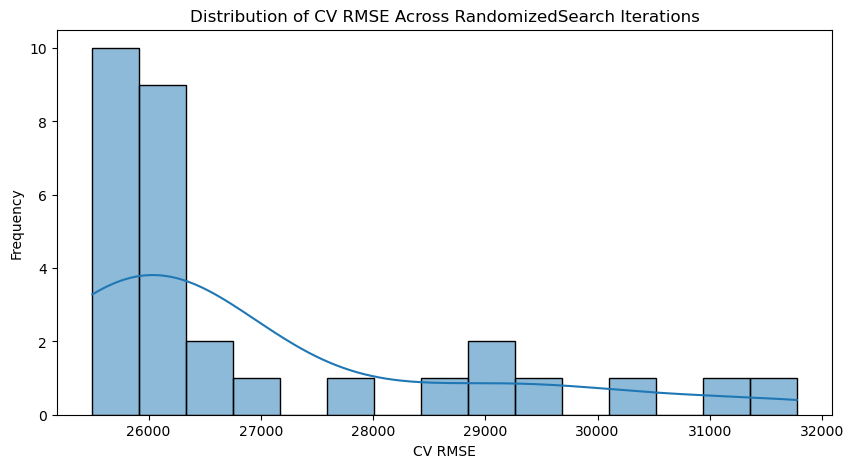

In [42]:
plt.figure(figsize=(10,5))
sns.histplot(-cv_results["mean_test_score"], bins=15, kde=True)
plt.title("Distribution of CV RMSE Across RandomizedSearch Iterations")
plt.xlabel("CV RMSE")
plt.ylabel("Frequency")
plt.show()

### Plot: Best scores over iterations

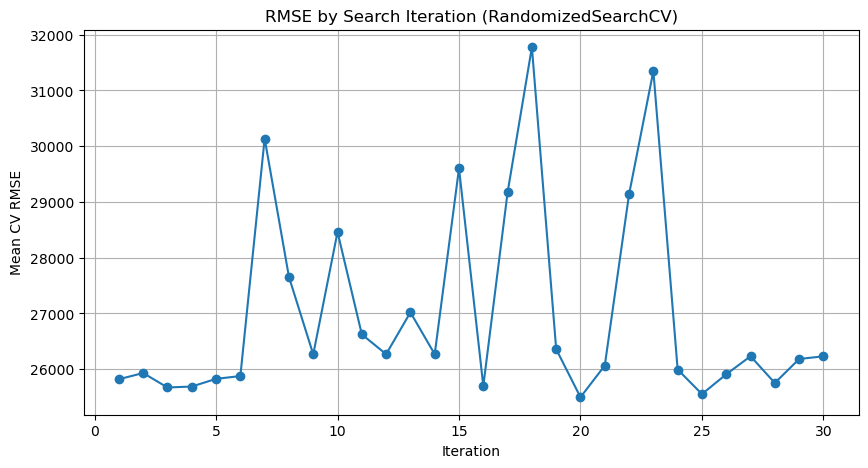

In [43]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cv_results)+1), -cv_results["mean_test_score"], marker='o')
plt.title("RMSE by Search Iteration (RandomizedSearchCV)")
plt.xlabel("Iteration")
plt.ylabel("Mean CV RMSE")
plt.grid(True)
plt.show()

### Feature importance from best model

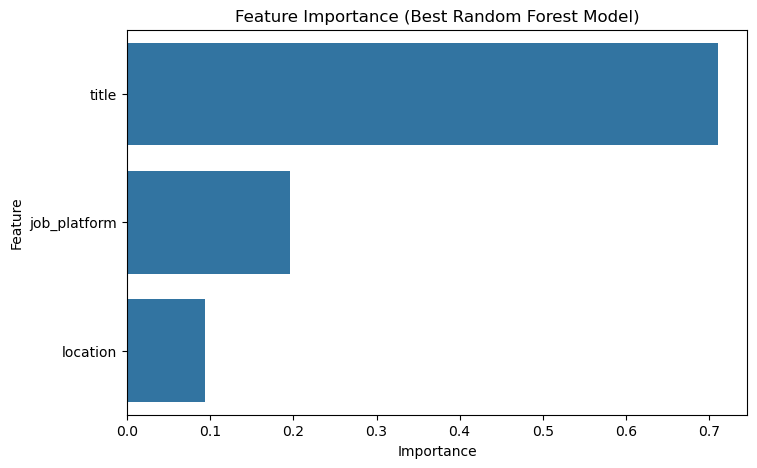

In [44]:
best_model = random_search.best_estimator_["model"]
importances = best_model.feature_importances_

feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_df, x="Importance", y="Feature")
plt.title("Feature Importance (Best Random Forest Model)")
plt.show()


### Final prediction function using the tuned model

In [45]:
def predict_salary(title, platform, location):
    sample = pd.DataFrame({
        "title": [title],
        "job_platform": [platform],
        "location": [location]
    })
    return random_search.best_estimator_.predict(sample)[0]


In [47]:
round(predict_salary('Senior Data Analyst', 'LinkedIn', 'United States'), 2)

np.float64(116347.28)

### Load the model

In [ ]:
import joblib
model = joblib.load("models/tuned_rf_pipeline.pkl")

### Use it anytime!

In [ ]:
sample = pd.DataFrame({
    "title": ["Data Analyst"],
    "job_platform": ["LinkedIn"],
    "location": ["United States"]
})

prediction = model.predict(sample)[0]
print("Predicted yearly salary:", round(prediction, 2))